In [0]:
import numpy as np
np.random.seed(1)

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
#torch.manual_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)

import math
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.1 GB
Cached:    0.2 GB


### MNIST dataset

**Loading the dataset**

In [0]:
train_batch = 64
test_batch = 64

kwargs = {}

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                                                          transform=transforms.Compose([transforms.ToTensor(),
                                                                                        transforms.Normalize((0.1307,), (0.3081,))])),
                                          batch_size=train_batch, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, 
                                                         transform=transforms.Compose([transforms.ToTensor(),
                                                                                       transforms.Normalize((0.1307,), (0.3081,))])),
                                          batch_size=test_batch, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


**Dataset visualization and preprocessing**

In [0]:
import seaborn as sns

The MNIST dataset consists of a set of 2D arrays consisting of pixel information defined on a $28 \times 28$  regular grid. If we wish to map the information of the regular grad to a graph we could compute the distance between each pixel 

In [0]:
import numpy as np
from scipy.spatial.distance import cdist
img_size = 28
col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size #Make coordinate pairs based on pixel index
dist = cdist(coord, coord)  # distances between all pairs of pixels

The resulting distance matrix is a $784 \times 784$ matrix which is equivalent to a complete graph consisting of 784 nodes and edges that are weighted by the distance between the pixels

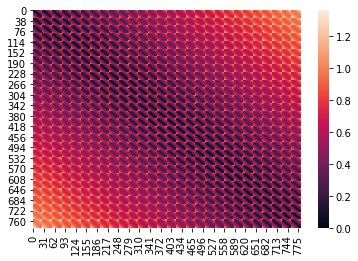

In [0]:
sns.heatmap(dist)

Using this distance matrix we can then turn it into an adjacency matrix through the use of a Gaussian kernel

$K(i,j)=\frac{1}{\sigma\sqrt{2\pi}}e^{\frac{d_{ij}}{2\sigma}}$

Where $\sigma$ controls the width of the nearest neighbour of $i$

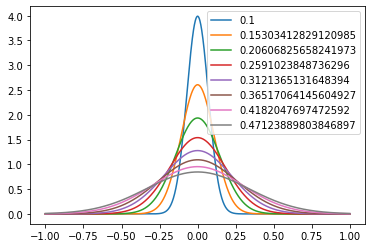

In [0]:
for sigma in np.linspace(0.1,0.15*math.pi,8):
  A = (1/(sigma*math.sqrt(2*math.pi)))*np.exp(- np.linspace(-1,1,1000)**2 / sigma ** 2)  # adjacency matrix of spatial similarity
  plt.plot(np.linspace(-1,1,1000),A, label=str(sigma))
plt.legend()


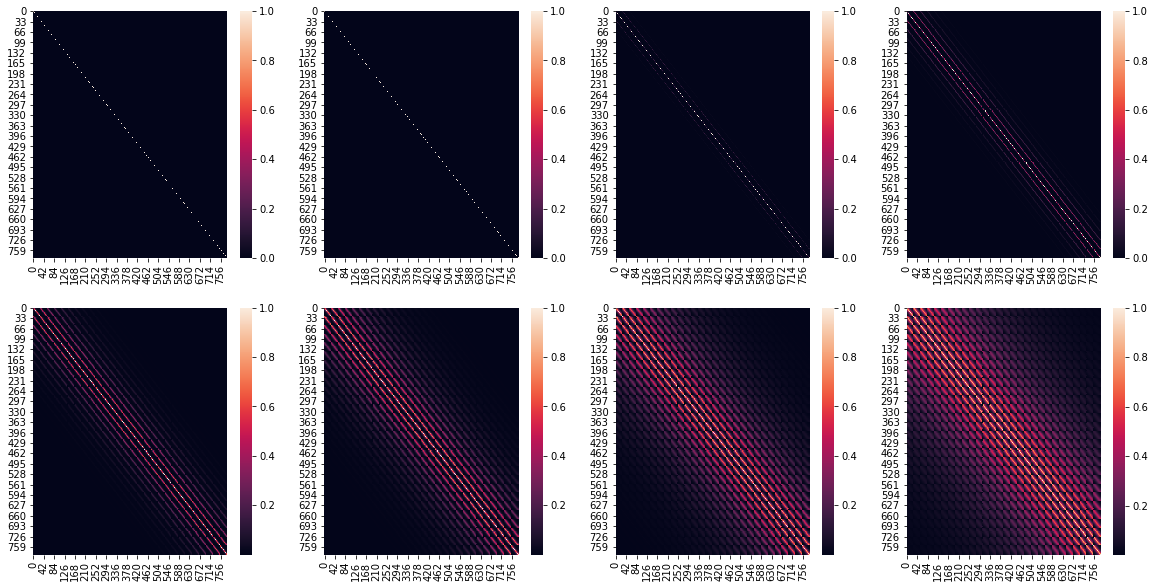

In [0]:
fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(20,10))
for ax, sigma in zip(axes.flatten(), np.linspace(0.001,0.15*math.pi,8)):
  A = np.exp(-dist / sigma ** 2)  # adjacency matrix of spatial similarity
  sns.heatmap(A, ax=ax)

With increasing $\sigma$ we get an adjacency matrix that is less sparse and thus more globally connected. 

In [0]:
A = np.exp(-dist**2 / (0.25 ** 2))

#Graph neural networks

## Graph convolution neural networks

### Spatial convolutions

Given an adjacency matrix *$\mathcal{A}$* (symmetric *N $\times$ N* matrix) and a feature vector *X* (*N $\times$ F*, with *F* the number of features per node) the spatial graph convolution later is defined as following when using the non-linearity *h*

$\tilde{A} = A+I_{N}$

$\tilde{D}_{ii} = \sum_{j} \tilde{A}_{ij}$

$\bar{A} = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$

$X^{(L+1)} = h \left(\bar{A}X^{(L)}W^{(L)}\right)$

Where $W^{(L)}$ is the spatial graph filter that is learned in layer *L*. As can be seen, each layer transforms the feature vector in such a way that it takes neighbourhood information into account.

**Reference**
*Semi-Supervised classification with graph convolutional networks* (https://arxiv.org/pdf/1609.02907.pdf)


### Spatial Graph Convolutional model

In [0]:
class SpatialGraphConv(torch.nn.Module):
  def __init__(self, 
               input_features, 
               output_features, bias=True):
    super(SpatialGraphConv, self).__init__()
    self.input_features = input_features
    self.output_features = output_features
    self.filter = nn.Linear(input_features, output_features)

  def forward(self, adjacency_matrix, vertex_features):
    aggregated_features = torch.matmul(adjacency_matrix, vertex_features)
    aggregated_features = aggregated_features.to(device)
    transformed_features =self.filter(aggregated_features)
    return transformed_features

In [0]:
class SpatialGraphNetwork(torch.nn.Module):
    def __init__(self):
        super(SpatialGraphNetwork, self).__init__()
        self.SPG_layer_1 = SpatialGraphConv(1,1)
        self.SPG_layer_2 = SpatialGraphConv(1,1)
        self.SPG_layer_3 = SpatialGraphConv(1,1)
        self.SPG_layer_4 = SpatialGraphConv(1,1)
        self.pooling = torch.nn.Linear(4,1)
        self.linear = torch.nn.Linear(784, 10)

    def forward(self, A, f):
        features_1 = torch.nn.Sigmoid()(self.SPG_layer_1(A, f))
        features_2 = torch.nn.Sigmoid()(self.SPG_layer_2(A, features_1))
        features_3 = torch.nn.Sigmoid()(self.SPG_layer_3(A, features_2))
        features_4 = torch.nn.Sigmoid()(self.SPG_layer_4(A, features_3))
        aggregated_features = torch.cat([features_1, features_2, features_3, features_4],2)
        pooled_features =  self.pooling(aggregated_features)
        pooled_features =  torch.nn.Sigmoid()(pooled_features)
        pooled_features = pooled_features.view(-1,1,784)
        output_features = self.linear(pooled_features)
        y_pred = F.log_softmax(output_features.view(-1,10), dim=1)
        return y_pred



In [0]:
def normalize_adjacency(A):
  D = np.sum(A, 0) # node degrees
  D_hat = np.diag((D + 1e-5)**(-0.5))
  return D_hat.dot(A).dot(D_hat)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SpatialGraphNetwork()
model = model.to(device)
A_hat = normalize_adjacency(A)
A_hat = torch.from_numpy(A_hat)
A_hat = A_hat.to(device)

In [0]:
def train(epoch, log_interval, cuda=False):
    #Set the internal state of the model to training mode
    #Some layers behabe differently during training then during the evaluation mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda is True:
            data, target = data.to(device), target.to(device)
        data = data.view(-1,784,1)
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(A_hat,data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.data))

In [0]:
def test(cuda=False):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda is True:
            data, target = data.to(device), target.to(device)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(A_hat, data.view(-1,784,1))
        test_loss += F.nll_loss(output, target, size_average=False).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
for epoch in range(100):
  train(epoch, 100,cuda=True)
  test(cuda=True)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.343323
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.378460
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.331728
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.372530
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.239763
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.302267
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.326221
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.299012
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.297792
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.304645


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.2917, Accuracy: 1441/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.260738
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.282206
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.260675
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.242230
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.096991
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.025158
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.889089
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.818925
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.554543
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.470481

Test set: Average loss: 1.5018, Accuracy: 5621/10000 (56%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.421727
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.515793
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.269816
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.246840
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.351729
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.346483
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.223609
Train Epoch: 2 [44800/60000 (75%)]	Loss:

### Spectral convolutions

# Graph Fourier basis


Spectral convolutions are defined as those that work on the graph frequency domain.

Suppose we have a Laplacian matrix $\mathcal{L}$ that is defined as 

$\Delta =  D-A$

where $\mathcal{A}$ is the adjacency matrix of the graph and $D$ the degree matrix. Diagonalization of the laplacian

$\Delta = \Phi \Lambda \Phi^T$

gives us a matrix $U$ that are the ordened eigenvectors for the graph charaterized by $\mathcal{L}$. The eigenvectors form a complete basis and represents the Fourier basis for the graph that describes the global graph structure.

Spectral filters that use this basis describe vertex correlations with respect to the global graph structure, i.e. the $complete$ neighbourhood of each node. 

The resulting graph convolution using the Fourier basis becomes

$ X^{L+1} = h\left(\Phi \theta^{L} \circ \Phi^TX^{L} \right)$



In [0]:
class SpectralGraphConv(torch.nn.Module):
  def __init__(self, 
               Phi,
               Phi_T):
    super(SpectralGraphConv, self).__init__()
    self.Phi = Phi
    self.Phi_T = Phi_T
    self.spectral_filter = torch.nn.Parameter(torch.rand((Phi.shape[0],1)))

  def forward(self, vertex_features):
    transformed_features = torch.matmul(self.Phi_T, vertex_features)
    transformed_spectral = torch.matmul(self.Phi, self.spectral_filter)
    transformed_features = torch.mul(transformed_spectral, transformed_features)
    return torch.nn.ReLU()(transformed_features)

class SpectralGraphNetwork(torch.nn.Module):
    def __init__(self,
                 Phi,
                 Phi_T):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(SpectralGraphNetwork, self).__init__()
        self.Phi = Phi
        self.Phi_T = Phi_T
        self.SG_layer_1 = SpectralGraphConv(self.Phi,self.Phi_T)
        self.SG_layer_2 = SpectralGraphConv(self.Phi,self.Phi_T)
        self.SG_layer_3 = SpectralGraphConv(self.Phi,self.Phi_T)
        self.SG_layer_4 = SpectralGraphConv(self.Phi,self.Phi_T)
        self.pooling = torch.nn.Linear(4,1)
        self.linear = torch.nn.Linear(784, 10)

    def forward(self,f):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        features_1 = torch.nn.Sigmoid()(self.SG_layer_1(f.double()))
        features_2 = torch.nn.Sigmoid()(self.SG_layer_2(features_1))
        features_3 = torch.nn.Sigmoid()(self.SG_layer_3(features_2))
        features_4 = torch.nn.Sigmoid()(self.SG_layer_4(features_3))
        aggregated_features = torch.cat([features_1, features_2, features_3, features_4],2)
        pooled_features =  self.pooling(aggregated_features)
        pooled_features =  torch.nn.Sigmoid()(pooled_features)
        pooled_features = pooled_features.view(-1,1,784)
        output_features = self.linear(pooled_features)
        y_pred = F.log_softmax(output_features.view(-1,10), dim=1)
        return y_pred


### Optimization functions

In [0]:
def train(epoch, log_interval, cuda=False):
    #Set the internal state of the model to training mode
    #Some layers behabe differently during training then during the evaluation mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda is True:
            data, target = data.to(device), target.to(device)
        data = data.view(-1,784,1)
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data.double())
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target.double())
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.data))

In [0]:
def test(cuda=False):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda is True:
            data, target = data.to(device), target.to(device)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model((data.view(-1,784,1)).double())
        test_loss += F.nll_loss(output, target, size_average=False).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


### Training

In [0]:
D = np.sum(A, 0)
D = np.diag(D)
L = D-A
_, Phi = np.linalg.eigh(L)
Phi_T = Phi.T
Phi = (torch.from_numpy(Phi)).double().to(device)
Phi_T = (torch.from_numpy(Phi_T)).double().to(device)

In [0]:
model = SpectralGraphNetwork(Phi, Phi_T)
model = model.to(device)


In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
for epoch in range(1,100):
  train(epoch, 100,cuda=True)
  test(cuda=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326469
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.320502
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.334923
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.346513
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.300008
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.263766
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.263993
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.214938
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.135886
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.958849


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.8706, Accuracy: 4475/10000 (45%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.894291
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.723508
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.396490
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.225215
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.962993
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.935831
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.879812
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.882237
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.805808
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.795185

Test set: Average loss: 0.6848, Accuracy: 8214/10000 (82%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.701663
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.608562
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.683515
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.526541
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.630023
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.494057
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.420798
Train Epoch: 3 [44800/60000 (75%)]	Loss:

## Approximation to the graph Fourier basis

As an approximation to this basis we can use the **Chebyshev polynomials of the first kind**. These polynomials are generated according to the following recursion relationship

$ T_{N+1}(x)= 2xT_{N}(x) - T_{N-1}(x) $

where 


*   $T_0(x) = 1 $
*   $T_1(x) = x $
*   $T_2(x) = 2x^2 -1$
*   $T_3(x) = 4x^3 -x$
*   $T_4(x) = 8x^4 - 8x^2 + 1$
*   $T_5(x) = 16x^5 - 20x^3 + 5x$
*   $T_6(x) = 32x^6 - 48x^4 +18x^2 -1$
*   ...

Increasing the order of the Chebyshev polynomial corresponds to the expansion of the graph neighbourhood. One can understand this as the order corresponding to the maximum amount of hops that are allowed to map the neighbourhood of the vertex in question.

In the limit of $N$ approaching the dimension of the adjacency matrix we can write an approximation to the Laplacian eigenbasis $U$

$\Phi \approx \sum_{i}^{N}\theta_i T_i(\tilde{\Delta})$

With $\tilde{\Delta}$ the normalized Laplacian given by

$\tilde{\Delta} = \frac{2}{\lambda_{max}}\Delta-I$

**Reference**

In [0]:
class ChebyshevGraphConv(torch.nn.Module):
  def __init__(self, 
               polynomial_order, 
               output_features,
               bias=True):
    super(ChebyshevGraphConv, self).__init__()
    self.polynomial_order = polynomial_order
    self.output_features = output_features
    self.filter = torch.nn.Linear(polynomial_order+1, output_features)

  def forward(self, chebyshev_matrices,vertex_features):
    """
    Generate a series of Chebyshev terms using the recursion formula. 
    After generation of these matrices apply matrix multiplication of each of these 
    to the initial feature vector which result in K 1D vector features. Subsequently combine these
    to a matrix and perform a linear mapping
    """
    chebyshev_features = [torch.matmul(chebyshev_matrix, vertex_features) for chebyshev_matrix in chebyshev_matrices]
    aggregated_features = torch.cat(chebyshev_features,2)
    transformed_features =self.filter(aggregated_features)
    return transformed_features

class ChebyshevGraphNetwork(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(ChebyshevGraphNetwork, self).__init__()
        self.CG_layer_1 = ChebyshevGraphConv(10,1)
        self.CG_layer_2 = ChebyshevGraphConv(10,1)
        self.CG_layer_3 = ChebyshevGraphConv(10,1)
        self.CG_layer_4 = ChebyshevGraphConv(10,1)
        self.pooling = torch.nn.Linear(4,1)
        self.linear = torch.nn.Linear(784, 10)

    def forward(self, A, f):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        features_1 = torch.nn.Sigmoid()(self.CG_layer_1(C, f))
        features_2 = torch.nn.Sigmoid()(self.CG_layer_2(C, features_1))
        features_3 = torch.nn.Sigmoid()(self.CG_layer_3(C, features_2))
        features_4 = torch.nn.Sigmoid()(self.CG_layer_4(C, features_3))
        aggregated_features = torch.cat([features_1, features_2, features_3, features_4],2)
        pooled_features =  self.pooling(aggregated_features)
        pooled_features =  torch.nn.Sigmoid()(pooled_features)
        pooled_features = pooled_features.view(-1,1,784)
        output_features = self.linear(pooled_features)
        y_pred = F.log_softmax(output_features.view(-1,10), dim=1)
        return y_pred


In [0]:
def generate_chebyshev_matrices(laplacian_matrix, polynomial_order):
  chebyshev_matrices = [torch.eye(laplacian_matrix.shape[0]).double(),laplacian_matrix]
  if polynomial_order > 1:
    while len(chebyshev_matrices)-1<polynomial_order:
      C = 2*torch.mm(laplacian_matrix,chebyshev_matrices[-1])-chebyshev_matrices[-2]
      C = C.to(device)
      chebyshev_matrices.append(2*torch.mm(laplacian_matrix,chebyshev_matrices[-1])-chebyshev_matrices[-2])
  return chebyshev_matrices

In [0]:
D = np.sum(A, 0)
D = np.diag(D)
L = D-A
eigenvalues, Phi = np.linalg.eigh(L)
lambda_max = np.amax(eigenvalues)

In [0]:
L_norm = (2/lambda_max)*L
L_norm = torch.from_numpy(L_norm)
L_norm = L_norm-torch.eye(784)
C = generate_chebyshev_matrices(L_norm.double(), 10)
C = [matrix.to(device) for matrix in C]

### Optimization functions

In [0]:
def train(epoch, log_interval, cuda=False):
    #Set the internal state of the model to training mode
    #Some layers behabe differently during training then during the evaluation mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda is True:
            data, target = data.to(device), target.to(device)
        data = data.view(-1,784,1)
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(C,data.double())
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.data))

In [0]:
def test(cuda=False):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda is True:
            data, target = data.to(device), target.to(device)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(C, data.view(-1,784,1).double())
        test_loss += F.nll_loss(output, target, size_average=False).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


### Training

In [0]:
model = ChebyshevGraphNetwork()
model = model.double().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
for epoch in range(1,100):
  train(epoch, 100,cuda=True)
  test(cuda=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.362989
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.322754
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.376321
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.281387
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.234204
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.992810
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.433570
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.025422
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.621505
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.653895


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.5969, Accuracy: 8495/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.578960
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.646941
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.391248
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.457512
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.564828
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.406312
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.419857
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.375826
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.368043
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.735155

Test set: Average loss: 0.3943, Accuracy: 8842/10000 (88%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.310730
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.527365
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.479193
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.279341
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.275791
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.530179
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.295480
Train Epoch: 3 [44800/60000 (75%)]	Loss:

### Overview

Above we have illustrated different implementations of Graph Convolutional networks. The following results have been obtained


*   Spatial Graph Convolution 88% accuracy
*   Spectral Graph Convolution 95% accuracy
*   Chebyshev Graph Convolution 95% accuracy

In comparison the convolutional network we trained in the pytorch tutorial roughly had 17000-18000 parameters in it to reach a accuracy of 99%.

The graph convolutional networks have the following amount of parameters all have roughly 8000 parameters (not optimal)


